# Acoustic Experiments

## Imports

In [1]:
%pylab inline

import numpy as np
import scipy as sp
import scipy.constants as const

from scipy.io import wavfile
from sklearn import preprocessing
from scipy import signal

from scipy.signal import butter, firwin, lfilter
from scipy.signal import freqz

Populating the interactive namespace from numpy and matplotlib


## Constants, Global Variables and Functions

In [2]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
duration = 0.1
tone_frequency = 8820
tone_period = 1/tone_frequency

scaler = preprocessing.MinMaxScaler()

samples = sample_rate * duration
time = np.linspace(0, duration, samples)
normedsin = lambda f,t : 2**13*sin(2*pi*f*t)

# Source: http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    low = low_cut_frequency / nyq
    high = high_cut_frequency / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    return lfilter(b, a, data)

def fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=5):
    nyq = 0.5 * fs
    b = firwin(order+1, [low_cut_frequency, high_cut_frequency], pass_zero=False, nyq=nyq)
    return b, [1.0]

def fir_bandpass_filter(data, low_cut_frequency, high_cut_frequency, fs, order=5):
    b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=order)
    return lfilter(b, a, data)

## Tone Generation

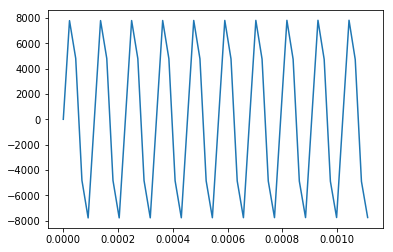

In [3]:
tone_path = input_data_directory+"/audio/tone.wav"

wave = lambda t : normedsin(tone_frequency,t)
tone_data = wave(time)

scaled_tone_data = scaler.fit_transform(np.reshape(tone_data,(tone_data.size,1)))

plot(time[0:50], tone_data[0:50])
wavfile.write(tone_path, sample_rate, tone_data.astype(np.int16))


## Load Sample Audio

In [4]:
sample_rate, sample_data = wavfile.read(input_data_directory+"/audio/sample.wav")
sample_duration = sample_data.size / sample_rate
print("Sample Rate: ",sample_rate,"\nSample Duration:",sample_duration)

scaled_sample_data = np.array(scaler.fit_transform(np.reshape(sample_data,(sample_data.size,1))).squeeze())

Sample Rate:  44100 
Sample Duration: 89.31555555555556


c:\developmenttools\anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int16 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [5]:
# plot(scaled_sample_data)

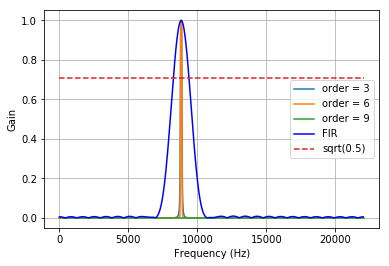

In [6]:
sample_rate
low_cut_frequency = tone_frequency - 50
high_cut_frequency = tone_frequency + 50

# Plot the frequency response for a few different filters and parameters.
plt.figure(1)
plt.clf()

for order in range(3,10,3):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

fir_order = 50
b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=fir_order)
w, h = freqz(b)
plt.plot((sample_rate * 0.5 / np.pi) * w , abs(h), 'b', label="FIR")
    
plt.plot([0, 0.5 * sample_rate], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

butler_order = 6
butler_filtered_sample_data = butter_bandpass_filter(scaled_sample_data,
                                                     low_cut_frequency,
                                                     high_cut_frequency,
                                                     sample_rate,
                                                     order=butler_order)

#fir_filtered_sample_data = fir_bandpass_filter(scaled_sample_data,
#                                               low_cut_frequency,
#                                               high_cut_frequency,
#                                               sample_rate,
#                                               order=fir_order)

filtered_sample_data = butler_filtered_sample_data

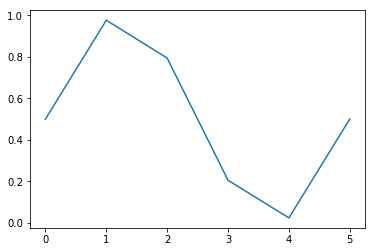

In [7]:
tone_match_data = scaled_tone_data[0:round(tone_period*sample_rate*1)+1].squeeze()
plot(tone_match_data)

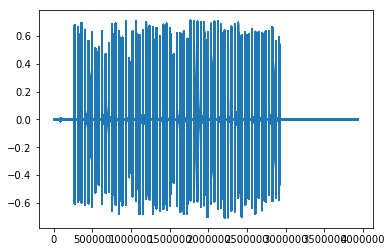

In [8]:
correlation = sp.correlate(filtered_sample_data, tone_match_data, 'valid')
plot(correlation)

In [9]:
treshold = 0.4
detected = False
last_index = 0
tone_indices = []

for index, value in enumerate(correlation):
    if value > treshold:
        if not detected:
            print ('Tone Detected at: ', index/sample_rate)
            tone_indices.append(index)            
        last_index = index
        detected = True
    elif index > last_index + sample_rate/2:
        detected = False

Tone Detected at:  6.125487528344671
Tone Detected at:  7.128775510204082
Tone Detected at:  8.124580498866214
Tone Detected at:  9.125714285714286
Tone Detected at:  10.131383219954648
Tone Detected at:  11.141383219954648
Tone Detected at:  12.127414965986395
Tone Detected at:  13.131950113378684
Tone Detected at:  14.143968253968254
Tone Detected at:  15.188299319727891
Tone Detected at:  16.175260770975058
Tone Detected at:  17.12424036281179
Tone Detected at:  18.127074829931974
Tone Detected at:  19.12517006802721
Tone Detected at:  20.128775510204083
Tone Detected at:  21.124126984126985
Tone Detected at:  22.129115646258505
Tone Detected at:  23.12517006802721
Tone Detected at:  24.12437641723356
Tone Detected at:  25.125850340136054
Tone Detected at:  26.125056689342404
Tone Detected at:  27.124580498866212
Tone Detected at:  28.124580498866212
Tone Detected at:  29.12482993197279
Tone Detected at:  30.124603174603173
Tone Detected at:  31.125056689342404
Tone Detected at:  32

In [10]:
len(tone_indices)

61